- Prophet is on PyPI, so you can use pip to install it. From v0.6 onwards, Python 2 is no longer supported. As of v1.0, the package name on PyPI is "prophet"; prior to v1.0 it was "fbprophet".

##### Resources FB Prophet
- https://sungkim11.medium.com/forecast-sales-using-prophet-with-regressors-b19adf8080ab
- https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57
- https://medium.com/mlearning-ai/multivariate-time-series-forecasting-using-fbprophet-66147f049e66
- https://www.analyticsvidhya.com/blog/2022/04/an-end-to-end-guide-on-time-series-forecasting-using-fbprophet/
- https://facebook.github.io/prophet/docs/quick_start.html
- https://www.jadsmkbdatalab.nl/forecasting-with-facebook-prophet-models-an-intro/

  ##### Algo comparison
- Neptune.AI: https://neptune.ai/blog/arima-vs-prophet-vs-lstm
- Kaggle: https://www.kaggle.com/code/aaronfloreani/forecasting-btc-arima-xgboost-prophet-lstm
- YouTube: https://www.youtube.com/watch?v=0gXeXtL_KjY

##### Notes
- For prediction windows we use cross validation, this is applicable to the trainig data.
- Making predictions on the test-set that has regressors is a 'cheat', as we are predicting data we can already see. (https://sungkim11.medium.com/forecast-sales-using-prophet-with-regressors-b19adf8080ab)

In [1]:

import util
import logging
import warnings
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
import plotly.graph_objs as go
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot


logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/pyn_m.csv')
df.head()
#df.describe().transpose()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [3]:
#Training and testing data
#data_train, data_test = util.prepare_data(df, 2016)
x=df['ds']
y=df['y']
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
train_df.tail()

,ds,y
2319,2014-06-11,7.439559
2320,2014-06-12,7.707962
2321,2014-06-13,7.350516
2322,2014-06-14,7.322510
2323,2014-06-15,7.285507


Hyperparameter tuning

##### Lasso Regression L1, Ridge Regression L2
- Because prophet has many places possible places for rate change, it uses L1 regularization
- By default changepoints are only inferred for the first 80% of the time series
 - If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

In [20]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}
#create cutoff dates
cutoffs = pd.to_datetime(['2013-02-15', '2013-04-15', '2013-08-15']) #Manually select dates 30 days apart
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

In [21]:
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

05:31:38 - cmdstanpy - INFO - Chain [1] start processing
05:31:38 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] start processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:41 - cmdstanpy - INFO - Chain [1] done processing
05:31:42 - cmdstanpy - INFO - Chain [1] start processing
05:31:42 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] done processing
05:31:44 - cmdstanpy - INFO - Chain [1] start processing
05:31:44 - cmdstanpy - INFO - Chain [1]

In [22]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

#best params
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


In [23]:
#Add country holidays model.add_country_holidays(country_name='UK')
model = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=10.0) #Use best parameters
model.add_country_holidays(country_name='US')
model.fit(train_df)

05:32:53 - cmdstanpy - INFO - Chain [1] start processing
05:32:53 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model.make_future_dataframe(periods=30, freq='D') #makefuture dataframe 30 days
forecast = model.predict(future)
plot_plotly(model, forecast)

##### Cross validation
- Horizon: the time to be predicted
-  Initial: the initial training period
- Period: the spacing between cut-off dates

In [28]:
#Here we do cross-validation to assess prediction performance on a horizon of 30 days,
# starting with 730 days of training data in the first cutoff and then making predictions after every  180 days.

df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '60 days')
df_cv.tail()

  0%|          | 0/9 [00:00<?, ?it/s]

05:34:23 - cmdstanpy - INFO - Chain [1] start processing
05:34:23 - cmdstanpy - INFO - Chain [1] done processing
05:34:24 - cmdstanpy - INFO - Chain [1] start processing
05:34:24 - cmdstanpy - INFO - Chain [1] done processing
05:34:24 - cmdstanpy - INFO - Chain [1] start processing
05:34:24 - cmdstanpy - INFO - Chain [1] done processing
05:34:25 - cmdstanpy - INFO - Chain [1] start processing
05:34:25 - cmdstanpy - INFO - Chain [1] done processing
05:34:25 - cmdstanpy - INFO - Chain [1] start processing
05:34:26 - cmdstanpy - INFO - Chain [1] done processing
05:34:26 - cmdstanpy - INFO - Chain [1] start processing
05:34:26 - cmdstanpy - INFO - Chain [1] done processing
05:34:27 - cmdstanpy - INFO - Chain [1] start processing
05:34:27 - cmdstanpy - INFO - Chain [1] done processing
05:34:28 - cmdstanpy - INFO - Chain [1] start processing
05:34:28 - cmdstanpy - INFO - Chain [1] done processing
05:34:28 - cmdstanpy - INFO - Chain [1] start processing
05:34:29 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
529,2014-06-11,7.372935,6.780691,8.018744,7.439559,2014-04-16
530,2014-06-12,7.355663,6.745049,7.962880,7.707962,2014-04-16
531,2014-06-13,7.345778,6.732542,7.946766,7.350516,2014-04-16
532,2014-06-14,7.135508,6.479814,7.735617,7.322510,2014-04-16
533,2014-06-15,7.491810,6.883527,8.130845,7.285507,2014-04-16


In [26]:
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

###### Plot Cross Validation

Text(2010-02-07 00:00:00, 6, 'Horizon')

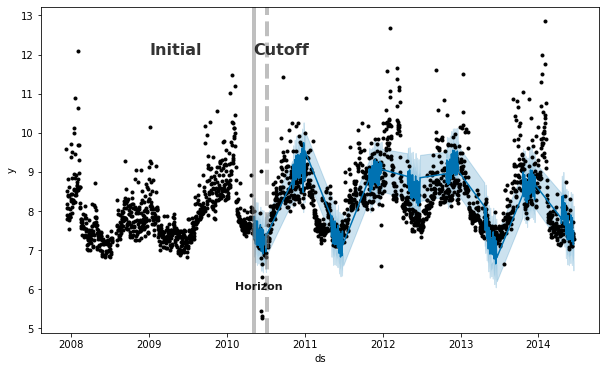

In [33]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(model.history['ds'].values, model.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2009-01-01'),y=12, s='Initial', color='black', #Initial training period 730 days
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2010-05-07'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('60 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2010-02-07'),y=6, s='Horizon', color='black',
       fontsize=11, fontweight='bold', alpha=0.9)

##### Perfomance metrics

In [16]:
perf_df = performance_metrics(df_cv)
perf_df.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,1.393010,1.180258,0.988829,0.112240,0.112240,0.121735,0.5
1,3 days,1.333692,1.154856,0.818127,0.090748,0.090748,0.099761,0.5
2,4 days,0.010588,0.102897,0.074265,0.010562,0.010562,0.010456,1.0
3,5 days,0.075404,0.274598,0.252772,0.036830,0.036830,0.036041,1.0
4,6 days,1.174058,1.083540,0.924756,0.163208,0.163208,0.146078,0.5


In [ ]:
#Plot change points
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
#Checkout holidays included in model training (model.train_holiday_names)
model.train_holiday_names

In [ ]:
fig = model.plot_components(forecast)